In [ ]:
!pip install cvxpy torch torchvision

In [ ]:
import numpy as np

def generate_device_weights(n_devices):
    weights = np.random.rand(n_devices)  # Generate random values
    return weights / np.sum(weights)

In [ ]:
# Parameters
NUM_PARTITIONS = 25  # Number of clients
BATCH_SIZE = 32
FL_ROUNDS = 100
LOCAL_EPOCHS = 10
NUM_SELECTED_CLIENTS = 10
CLASSES_PER_CLIENT = 2
save_dir='./client_data'
batch_size: int = 32

In [ ]:
import numpy as np
import pandas as pd

def print_probability_table(probabilities, device_class_assignments):
    """
    Print a table showing the probability distribution for each device and class.

    Parameters:
    - probabilities: Optimized probability matrix (d x l)
    - device_class_assignments: List of class combinations assigned to each device
    """
    d, l = probabilities.shape

    # Create a DataFrame for better visualization
    table_data = []
    for i in range(d):
        row = {f"Class {j}": probabilities[i, j] for j in range(l)}
        row["Assigned Classes"] = device_class_assignments[i]
        table_data.append(row)

    df = pd.DataFrame(table_data)
    df.index = [f"Device {i+1}" for i in range(d)]

    print("\nProbability Distribution Table:")
    print(df)

In [ ]:
import os
import torch
import numpy as np
import itertools
import cvxpy as cp
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from math import comb
import random
import torch
import gzip
import os

def compress_tensor_data(client_data):
    compressed = []
    for x, y in client_data:
        # Convert image to float16 and label to int
        x = x.to(dtype=torch.float16)
        compressed.append((x, y))
    return compressed

def load_non_iid_datasets(num_partitions, classes_per_device, device_weights=None):
    # Load CIFAR-10 dataset
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    # Extract data and labels
    data, labels = next(iter(trainloader))
    n = len(labels)  # Total number of instances

    # Count instances per class
    n_records_class = np.bincount(labels.numpy(), minlength=10)

    # Generate class combinations for devices
    all_combinations = list(itertools.combinations(range(10), classes_per_device))
    class_combinations = all_combinations

    # if num_partitions <= len(all_combinations):
    #     class_combinations = random.sample(all_combinations, num_partitions)
    # else:
    #     raise ValueError("num_partitions exceeds the number of available class combinations.")
    osdd = len(all_combinations)
    # n_copies = int(np.ceil(num_partitions / osdd))
    n_copies = 25
    n_devices = n_copies * osdd
    print(f"n divice:{n_devices}")
    print(f"class :{class_combinations}")

    device_weights = generate_device_weights(n_devices)

    print(f"device weights:{device_weights}")

    # Assign weights to devices (if not provided, use equal weights)
    if device_weights is None:
        device_weights =  np.ones(n_devices) / n_devices
    else:
        device_weights = np.array(device_weights)
        device_weights /= np.sum(device_weights)  # Normalize weights

    # Initialize probability matrix
    d, l = n_devices, 10
    print(f"d and l: {d}/{l}")
    p = cp.Variable((d, l))
    print(f"p: {p}")

    # Define constraints
    constraints = []

    # Ensure probabilities for each device sum to 1
    for i in range(d):
        constraints.append(cp.sum(p[i, :]) >= 0)  # Allow some flexibility
        constraints.append(cp.sum(p[i, :]) <= 1)


    # Probabilities per class follow expected instance distribution with weighting
    for j in range(l):
        constraints.append(cp.sum(cp.multiply(device_weights, p[:, j])) == n_records_class[j] / n)

    # Probabilities are non-negative
    constraints.append(p >= 0)

    # Assign classes to devices
    device_class_assignments = []
    for i in range(d):
        if i < osdd:
            device_class_assignments.append(class_combinations[i])
        else:
            device_class_assignments.append(class_combinations[i % osdd])

    # Set probabilities to zero for unassigned classes
    for i in range(d):
        for j in range(l):
            if j not in device_class_assignments[i]:
                constraints.append(p[i, j] == 0)

    # Objective function to distribute probabilities evenly among selected classes
    alpha = np.random.uniform(0, 1, size=(d, l))
    objective = cp.Minimize(cp.sum_squares(p - alpha))

    # Solve optimization problem
    prob = cp.Problem(objective, constraints)
    # prob.solve()
    # prob.solve(solver=cp.OSQP, eps_abs=1e-7, eps_rel=1e-7)
    prob.solve(solver=cp.SCS)
    print(f"Solver status: {prob.status}")


    # Compute expected instances per device per class
    print(f"p.value is :{p.value}")
    expected_instances = (p.value * n) * device_weights[:, np.newaxis]
    expected_instances = np.round(expected_instances).astype(int)  # Convert to integer counts

    device_data = [[] for _ in range(d)]
    for class_idx in range(l):
        class_indices = np.where(labels == class_idx)[0]

        # Calculate probabilities of selecting each device for this class
        probs = p.value[:, class_idx].copy()  # Make a copy to avoid modifying original

        # Handle numerical precision issues by clipping negative values
        probs = np.clip(probs, 0, None)  # Clip any negative values to zero

        # Normalize probabilities if their sum is positive
        if np.sum(probs) > 0:
            probs = probs / np.sum(probs)
        else:
            # If all probabilities are zero, distribute uniformly to valid devices
            valid_devices = [i for i in range(d) if class_idx in device_class_assignments[i]]
            probs = np.zeros(d)
            if valid_devices:
                probs[valid_devices] = 1.0 / len(valid_devices)
            else:
                # Fallback: uniform distribution across all devices
                probs = np.ones(d) / d

        # Generate device assignments for all instances of this class at once
        # This follows the paper's approach of generating a sample of size n_j
        device_assignments = np.random.choice(d, size=len(class_indices), p=probs)

        # Assign instances to devices based on generated assignments
        for idx, device_idx in zip(class_indices, device_assignments):
            device_data[device_idx].append((data[idx], labels[idx]))





    # Verify non-i.i.d. property
    for i, data in enumerate(device_data):
        if data:
            classes, counts = np.unique([y for _, y in data], return_counts=True)
            print(f"Device {i+1} classes and counts: {dict(zip(classes, counts))}")
        else:
            print(f"Device {i+1} is empty.")

        #Save each client's data to disk
    os.makedirs(save_dir, exist_ok=True)

    for i, client_data in enumerate(device_data):
        if client_data:
            client_file_path = os.path.join(save_dir, f"client_{i}.pt.gz")
            compressed_data = compress_tensor_data(client_data)

            with gzip.open(client_file_path, 'wb') as f:
                torch.save(compressed_data, f)

            print(f"Client {i+1} compressed and saved to {client_file_path}")
        else:
            print(f"Client {i+1} has no data.")
    return device_data


In [ ]:
num_partitions = 25
classes_per_device = 10
all_device_data = load_non_iid_datasets(num_partitions, classes_per_device, device_weights=None)


In [ ]:
# For example, with 10 devices where first few have more weight
# device_weights = [0.2, 0.2, 0.15, 0.15, 0.1, 0.05, 0.05, 0.05, 0.03, 0.02]
num_partitions = 25
classes_per_device = 10
load_non_iid_datasets(num_partitions, classes_per_device, device_weights=None)

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np


def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
    if not only_server_test_data:
        # Load the compressed and saved data for the partition
        partition_data_path = os.path.join(save_dir, f'client_{partition_id}.pt.gz')
        print(f"Loading client: {partition_id} from {partition_data_path}")

        with gzip.open(partition_data_path, 'rb') as f:
            device_data = torch.load(f, map_location='cpu')

        # Convert tensors to float32 if needed
        device_data = [(x.to(dtype=torch.float32), y) for x, y in device_data]

        # Divide data into 80% train and 20% test
        np.random.shuffle(device_data)
        train_size = int(len(device_data) * 0.8)
        train_data = device_data[:train_size]
        test_data = device_data[train_size:]

        # Define PyTorch transforms for normalization only
        pytorch_transforms = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization only, no ToTensor
        ])

        # Apply transforms to data
        train_data = [(pytorch_transforms(x), y) for x, y in train_data]
        test_data = [(pytorch_transforms(x), y) for x, y in test_data]

        # Create data loaders
        trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
        valloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=1)

        return trainloader, valloader
    else:
        # Load the test set for CIFAR-10 from the original dataset (if needed separately for validation)
        testset = torchvision.datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        )
        testloader = DataLoader(testset, batch_size=batch_size, num_workers=8)

        return testloader

In [ ]:
# For example, with 10 devices where first few have more weight
# device_weights = [0.2, 0.2, 0.15, 0.15, 0.1, 0.05, 0.05, 0.05, 0.03, 0.02]
# num_partitions = 20
# classes_per_device = 10
# load_non_iid_datasets(num_partitions, classes_per_device, device_weights=None)


In [ ]:
# Load data for all clients and calculate label distributions
from collections import Counter

label_distributions = []
for client_id in range(25):
    trainloader, _ = load_data_from_disk(client_id, False)
    labels = []
    for batch in trainloader:
        if len(batch) != 2:
            raise ValueError(f"Unexpected batch structure: {batch}")
        labels.extend(batch[1].tolist())
    label_distributions.append(Counter(labels))


Loading client: 0 from /content/client_data/client_0.pt.gz
Loading client: 1 from /content/client_data/client_1.pt.gz
Loading client: 2 from /content/client_data/client_2.pt.gz
Loading client: 3 from /content/client_data/client_3.pt.gz
Loading client: 4 from /content/client_data/client_4.pt.gz
Loading client: 5 from /content/client_data/client_5.pt.gz
Loading client: 6 from /content/client_data/client_6.pt.gz
Loading client: 7 from /content/client_data/client_7.pt.gz
Loading client: 8 from /content/client_data/client_8.pt.gz
Loading client: 9 from /content/client_data/client_9.pt.gz
Loading client: 10 from /content/client_data/client_10.pt.gz
Loading client: 11 from /content/client_data/client_11.pt.gz
Loading client: 12 from /content/client_data/client_12.pt.gz
Loading client: 13 from /content/client_data/client_13.pt.gz
Loading client: 14 from /content/client_data/client_14.pt.gz
Loading client: 15 from /content/client_data/client_15.pt.gz
Loading client: 16 from /content/client_data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

# Plot label distributions for each client
fig, axs = plt.subplots(25, 1, figsize=(10, 80))
for i, (ax, distribution) in enumerate(zip(axs, label_distributions)):
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))  # Set ticks for 0 to 9
    ax.set_xticklabels(range(10))  # Set labels for 0 to 9
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

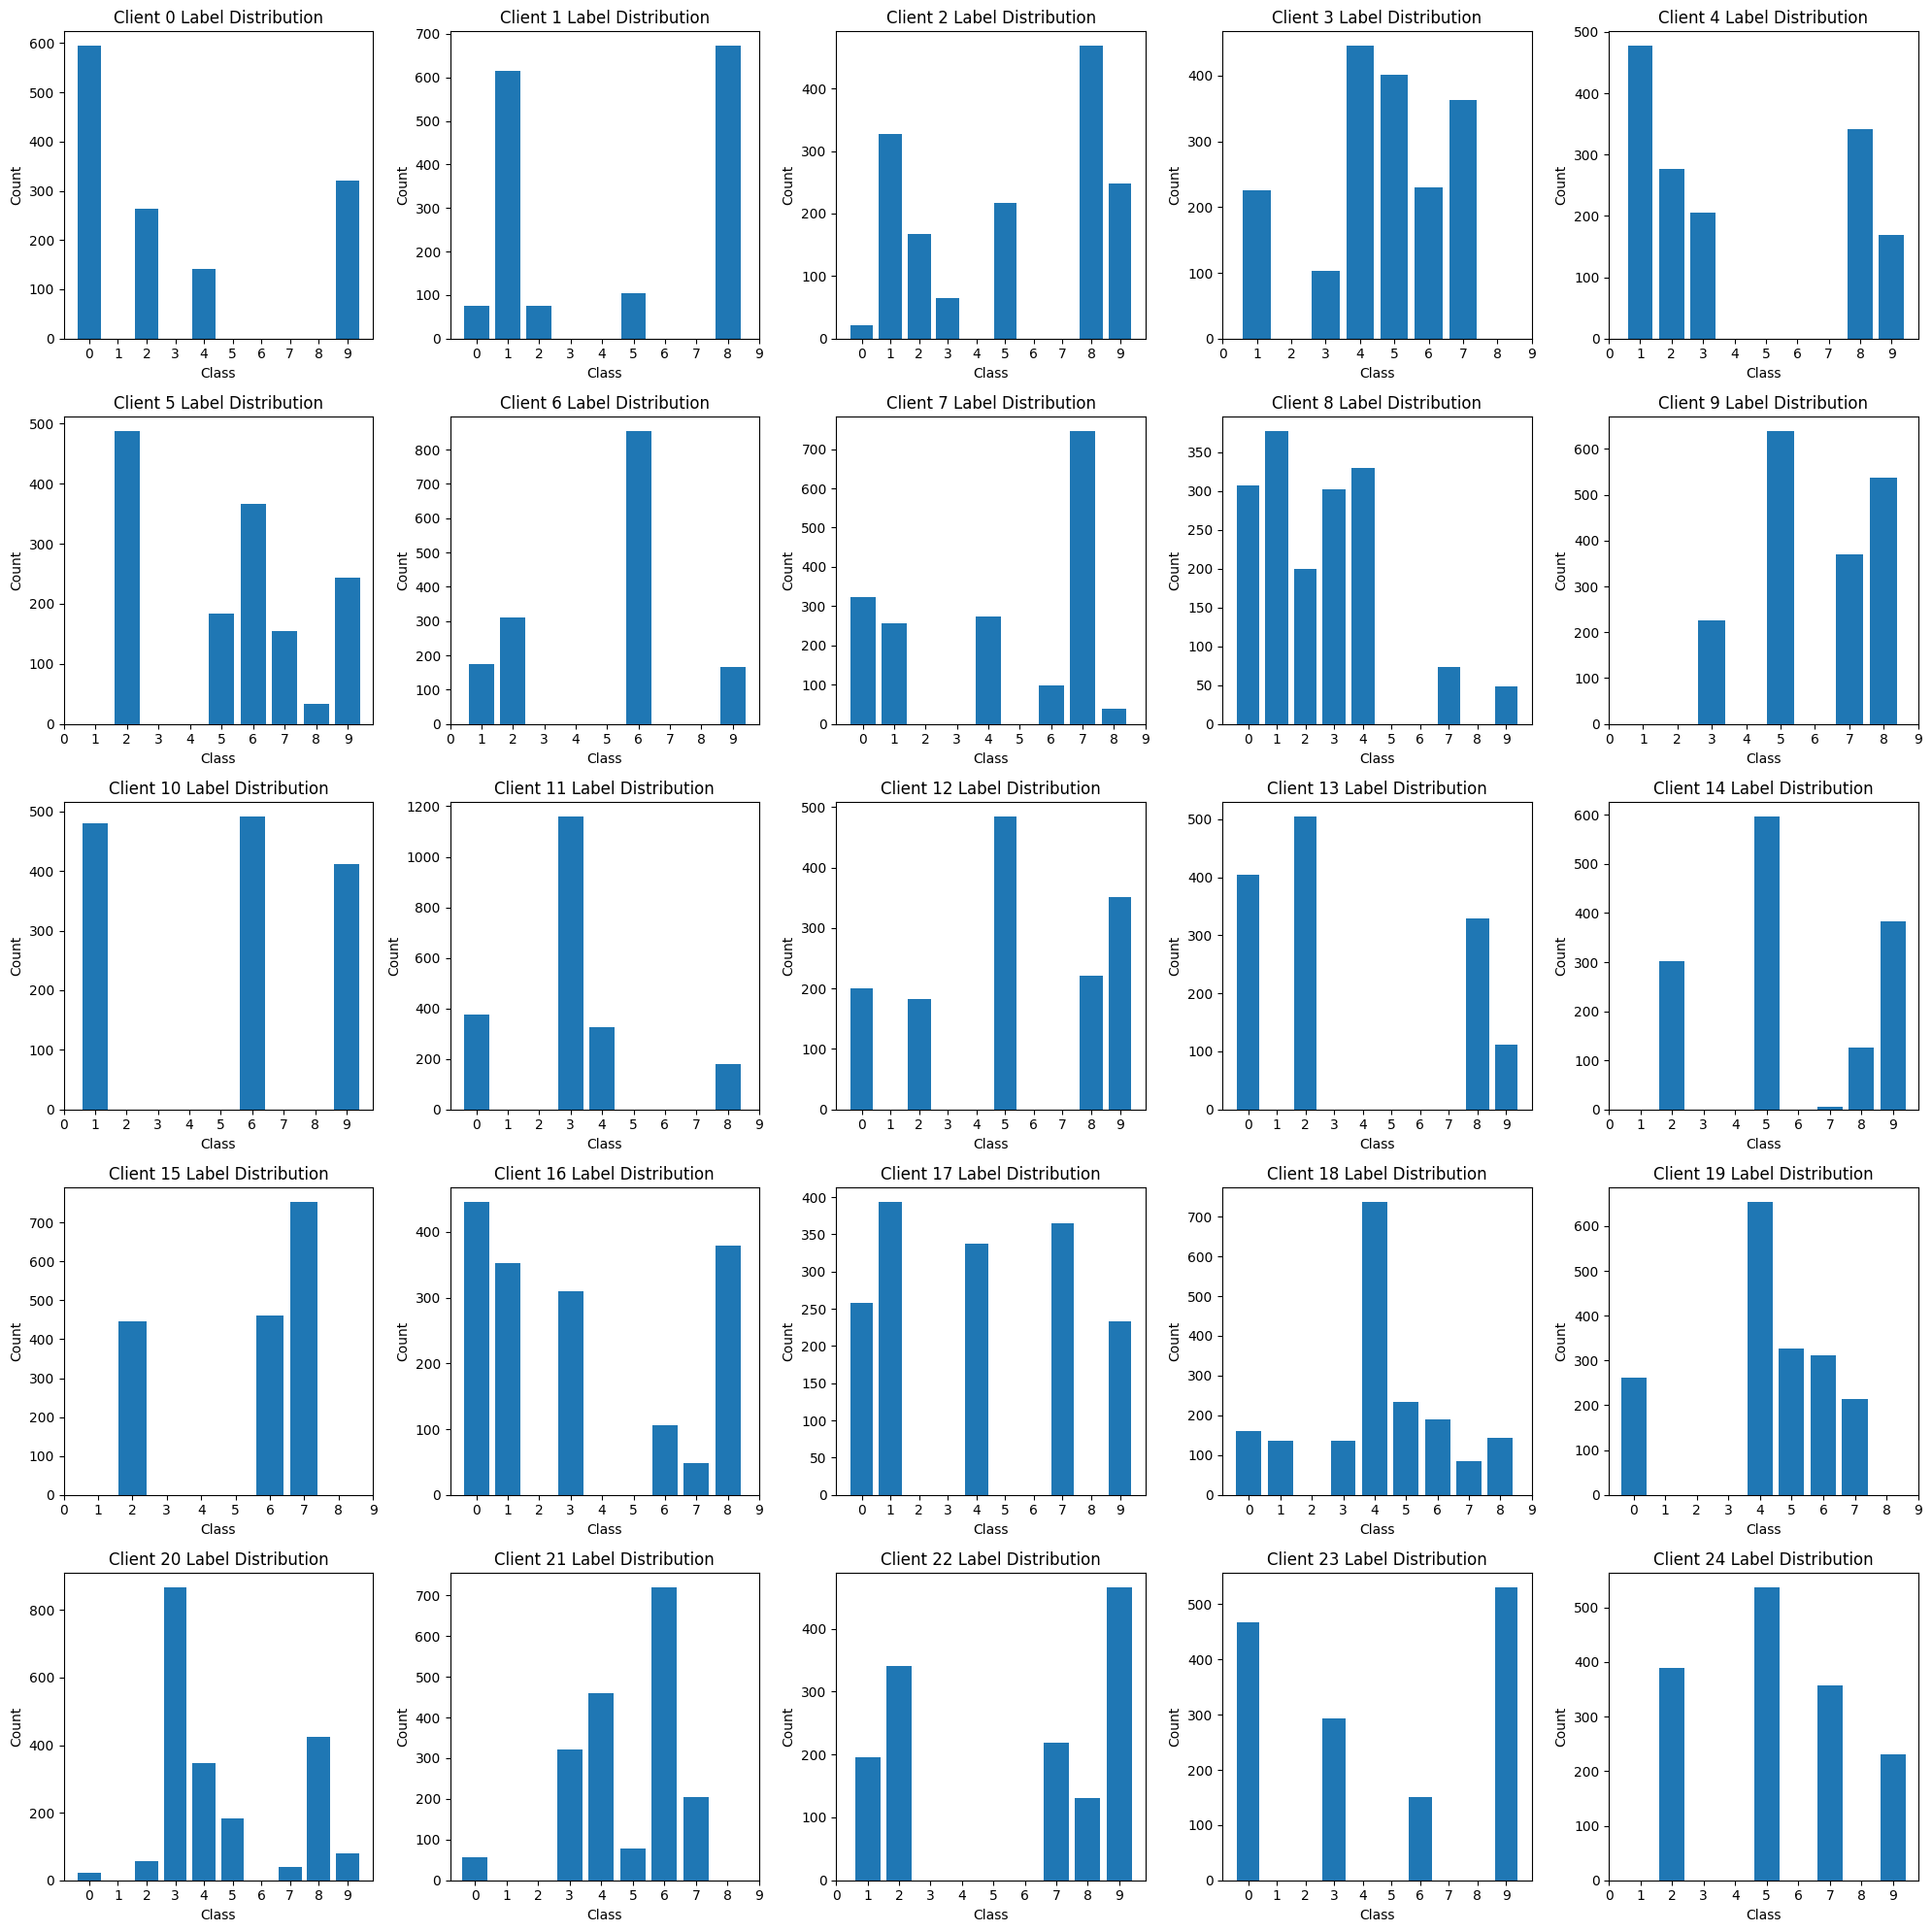

In [ ]:
import matplotlib.pyplot as plt

# Assuming label_distributions is a list of dictionaries (one per client)
fig, axs = plt.subplots(5, 5, figsize=(20, 20))  # 5 rows, 5 columns

for i, (ax, distribution) in enumerate(zip(axs.flat, label_distributions)):
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

# Hide any unused subplots (if label_distributions < 25)
for j in range(len(label_distributions), 25):
    fig.delaxes(axs.flat[j])

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil
import os

# Set your save directory and target path in Google Drive
save_dir = '/content/client_data'  # update if your directory is different
target_drive_dir = '/content/drive/MyDrive/client_data_backup'

# Copy to Drive
shutil.copytree(save_dir, target_drive_dir)

print(f"Client data copied to: {target_drive_dir}")


Client data copied to: /content/drive/MyDrive/client_data_backup
